## Этап 1. Получение и предобработка данных

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

Прочитаем файлы и сохраним его в переменные

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv') 
ad_costs = pd.read_csv('/datasets/costs_info_short.csv')
events = None

Удалим явные дубликаты

In [3]:
visits = visits.drop_duplicates()
orders = orders.drop_duplicates()
ad_costs = ad_costs.drop_duplicates()

Общая информация о данных таблиц

In [4]:
visits.info()
print('---------------------')
orders.info()
print('---------------------')
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 16.6+ MB
---------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB
---------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 0 to 1799
Data

Переименуем столбцы для удобства дальнейшей работы

In [5]:
visits = visits.rename(columns = {'User Id' : 'user_id', 'Region' : 'region', 'Device' : 'device', 'Channel' : 'channel', 'Session Start' : 'session_start', 'Session End' : 'session_end'})
orders = orders.rename(columns = {'User Id' : 'user_id', 'Event Dt' : 'event_dt', 'Revenue' : 'revenue'})
ad_costs = ad_costs.rename(columns = {'Channel' : 'channel'})

Присвоим данным соответствующий им тип

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])

Получение первых и последних строк таблиц

In [7]:
visits

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
...,...,...,...,...,...,...
309896,329994900775,UK,PC,LeapBob,2019-10-31 13:28:12,2019-10-31 14:39:29
309897,334903592310,France,PC,lambdaMediaAds,2019-10-31 22:14:52,2019-10-31 22:39:36
309898,540102010126,Germany,PC,organic,2019-10-31 01:40:48,2019-10-31 01:41:31
309899,308736936846,Germany,Mac,organic,2019-10-31 07:37:34,2019-10-31 07:37:55


In [8]:
orders

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


In [9]:
ad_costs

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


**Выводы**

Данные загружены, пропуски и дубликаты устарнены, если имелись, названия и типы данных исправлены, данные готовы к к анализу.

## Этап 2. Анализ данных

Создадим функции для расчёта и анализа LTV, ROI, удержания и конверсии:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### get_profiles()

In [10]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### get_retention()

In [11]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### get_conversion()

In [12]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### get_ltv()

In [13]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### filter_data()

In [14]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### plot_retention()

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### plot_conversion()

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### plot_ltv_roi

In [17]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Сформируем профили пользователей

In [18]:
events = None

In [19]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].astype('datetime64[D]')
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [20]:
profiles = get_profiles(visits, orders, events, ad_costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


В данных представлены записи о 150 008 пользователях, для них указаны дата первого посещения, регион, устройство, канал привлечения.

Определим минимальную и максимальную даты привлечения

In [21]:
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()

In [22]:
min_analysis_date

Timestamp('2019-05-01 00:00:00')

In [23]:
observation_date

Timestamp('2019-10-27 00:00:00')

Самый "старый" пользователь был привлечён 1-го мая 2019-го, а самый "молодой" - 27-го октября 2019-го, то-есть наблюдаемый период составляет почти пол года, как и указано в описании проекта:
>Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года


Определим долю платящих пользователей в зависимости от страны

In [24]:
users_by_region = ( 
    profiles.groupby('region')
    .agg({'user_id': 'count', 'payer':'sum'})
    .rename(columns={'user_id': 'users_cnt','payer': 'payers_cnt'})
    .reset_index()
)
 
users_by_region['payers_share']= 100 * (users_by_region['payers_cnt'] / users_by_region['users_cnt'])
users_by_region.sort_values(by='payers_share', ascending=False).style.format({'payers_share':'{:.2f}%'})

,region,users_cnt,payers_cnt,payers_share
3,United States,100002,6902,6.90%
1,Germany,14981,616,4.11%
2,UK,17575,700,3.98%
0,France,17450,663,3.80%


Большего всего пользователей проживают в США, там же больше всего платящих пользователей, как в абсолютных, так и в относительных значених.

Определим долю платящих пользователей в зависимости от устройства

In [25]:
users_by_device = ( 
    profiles.groupby('device')
    .agg({'user_id': 'count', 'payer':'sum'})
    .rename(columns={'user_id': 'users_cnt','payer': 'payers_cnt'})
    .reset_index()
)
 
users_by_device['payers_share']= 100 * (users_by_device['payers_cnt'] / users_by_device['users_cnt'])
users_by_device.sort_values(by='payers_share', ascending=False).style.format({'payers_share':'{:.2f}%'})

,device,users_cnt,payers_cnt,payers_share
1,Mac,30042,1912,6.36%
3,iPhone,54479,3382,6.21%
0,Android,35032,2050,5.85%
2,PC,30455,1537,5.05%


Наиболее поплярно наше приложение среди пользователей iPhone-ов, так же в этой кагорте больше всего платящих пользователей. Однако пользователи Mac-ов с большей вероятностью конвертируются в платящих.

Определим долю платящих пользователей в зависимости от источника трафика

In [26]:
users_by_channel = ( 
    profiles.groupby('channel')
    .agg({'user_id': 'count', 'payer':'sum'})
    .rename(columns={'user_id': 'users_cnt','payer': 'payers_cnt'})
    .reset_index()
)
 
users_by_channel['payers_share']= 100 * (users_by_channel['payers_cnt'] / users_by_channel['users_cnt'])
users_by_channel.sort_values(by='payers_share', ascending=False).style.format({'payers_share':'{:.2f}%'})

,channel,users_cnt,payers_cnt,payers_share
1,FaceBoom,29144,3557,12.20%
0,AdNonSense,3880,440,11.34%
9,lambdaMediaAds,2149,225,10.47%
6,TipTop,19561,1878,9.60%
5,RocketSuperAds,4448,352,7.91%
7,WahooNetBanner,8553,453,5.30%
8,YRabbit,4312,165,3.83%
3,MediaTornado,4364,156,3.57%
2,LeapBob,8553,262,3.06%
4,OppleCreativeMedia,8605,233,2.71%


Лидером по всем параметрам (количеству пользователей, количеству платящих пользователей и доле платящих пользователей) является источник 'FaceBoom'. На втором месте по количеству - TipTop, по качеству - AsNonSense.

**Промежуточные выводы 1**

Лучше всего сосредоточиться на привлечении пользователей из США, которые сидят в FaceBoom через свой Mac.

Посчитаем общую сумму расходов

In [27]:
total_costs = round(ad_costs['costs'].sum())
total_costs

105497

Общая сумма расходов - 105 497 денег.

Определим расходы на каждый источник трафика

In [28]:
costs_by_channel = ( 
    ad_costs.groupby('channel')
    .agg({'costs':'sum'})
    .rename(columns={'costs': 'costs_by_channel'})
    .reset_index()
)
 
costs_by_channel['channel_cost_share']= 100 * (costs_by_channel['costs_by_channel'] / total_costs)
costs_by_channel.sort_values(by='channel_cost_share', ascending=False).style.format({'costs_by_channel':'{:.0f}', 'channel_cost_share':'{:.2f}%'})

,channel,costs_by_channel,channel_cost_share
6,TipTop,54751,51.90%
1,FaceBoom,32446,30.75%
7,WahooNetBanner,5151,4.88%
0,AdNonSense,3911,3.71%
4,OppleCreativeMedia,2151,2.04%
5,RocketSuperAds,1833,1.74%
2,LeapBob,1798,1.70%
9,lambdaMediaAds,1558,1.48%
3,MediaTornado,954,0.90%
8,YRabbit,944,0.90%


Больше половины денег потрачено на TipTop, при том, что, как мы выяснили ранее, он лишь на втором месте по количеству привлечённых пользователей и аж на четвёртом по качеству.

Визуализируем динамику расходов во времени

In [29]:
ad_costs['month'] = ad_costs['dt'].dt.month
ad_costs['week'] = ad_costs['dt'].dt.isocalendar().week

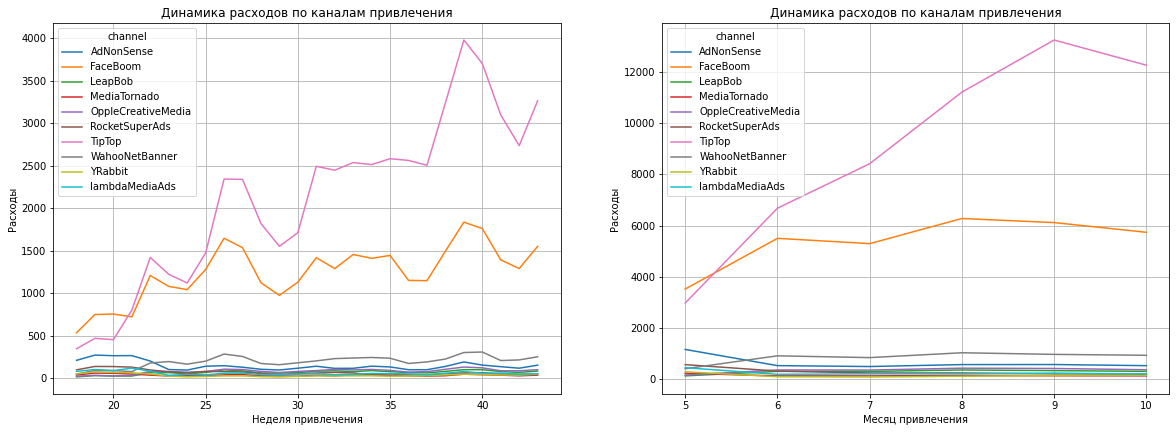

In [30]:
ax1 = plt.subplot(2, 2, 1)
ad_costs.pivot_table(
    index='week', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, ax=ax1, figsize=(20, 15))
plt.ylabel('Расходы')
plt.xlabel('Неделя привлечения')
plt.title('Динамика расходов по каналам привлечения')

ax2 = plt.subplot(2, 2, 2)
ad_costs.pivot_table(
    index='month', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, ax=ax2, figsize=(20, 15))
plt.ylabel('Расходы')
plt.xlabel('Месяц привлечения')
plt.title('Динамика расходов по каналам привлечения')

plt.show()

Видим, что только два канала привлечения были в фокусе в течении представленных шести месяцев - TipTop и FaceBoom. На рекламу в FaceBoom стабильно выделялось примерно 6000 денег в месяц, то на TipTop с каждым месяцев, кроме октября, выделяли всё больше и больше, начиная с 3000 денег в мае и заканчивая 13000 в сентябре. При этом мы уже знаем, что FaceBoom выиграл и по качеству, и по количеству привлечённых пользователей.

Рассчитаем САС

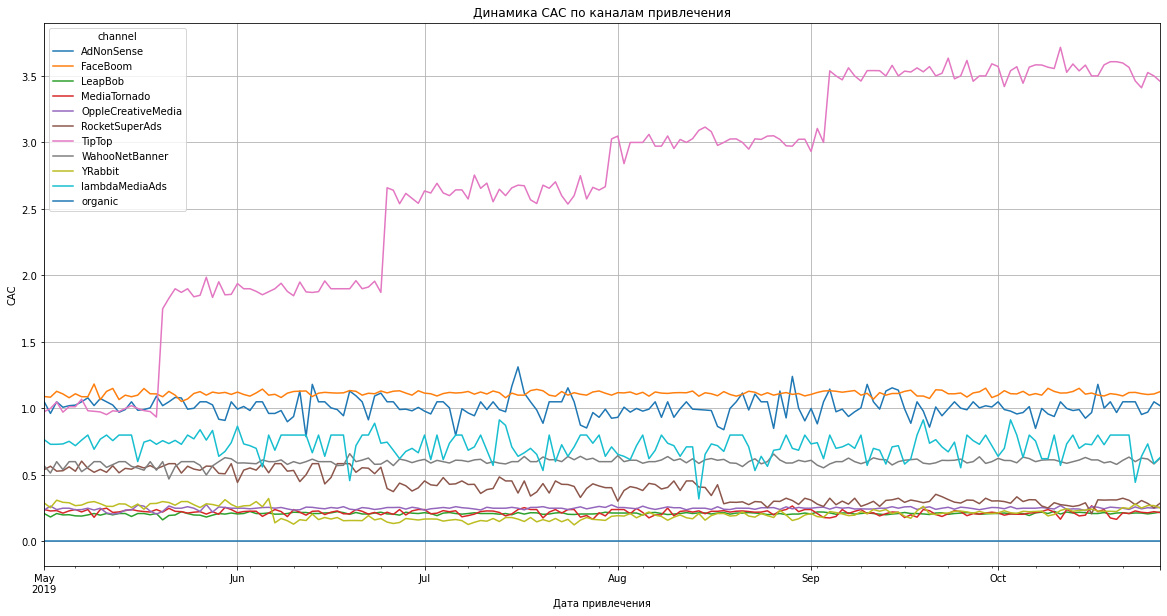

In [31]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(20, 10))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

In [32]:
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)

cac.sort_values(by='cac', ascending=False)

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Видим, что привлечение одного пользователя из рекламной сети «TipTop» с каждым месяцем дорожало на 0.5-1 и в среднем за пол года обошлось компании в 2.8 денег. Один пользователей из FaceBoom в среднем стоил 1.1 на всём временном промежутке. Привлечение пользователей по другим каналом трафика стоило от 0.2 до 1.

**Промежуточные выводы 2**

Более 80% ресурсов было потрачено на два источника трафика: TipTop (50%) и FaceBoom (30%). При этом расходы на TipTop ежемесячно увеличивались в течении четырёх месяцев подряд, что не помогло "победить" FaceBoom.

Исключим из анализа органических пользователей

In [33]:
purchased_profiles = profiles.query('channel != "organic"')

Определим моент и горизонт анализа

In [34]:
observation_date = pd.to_datetime('2020-11-01') 
horizon_days = 14 

Построим графики LTV и ROI

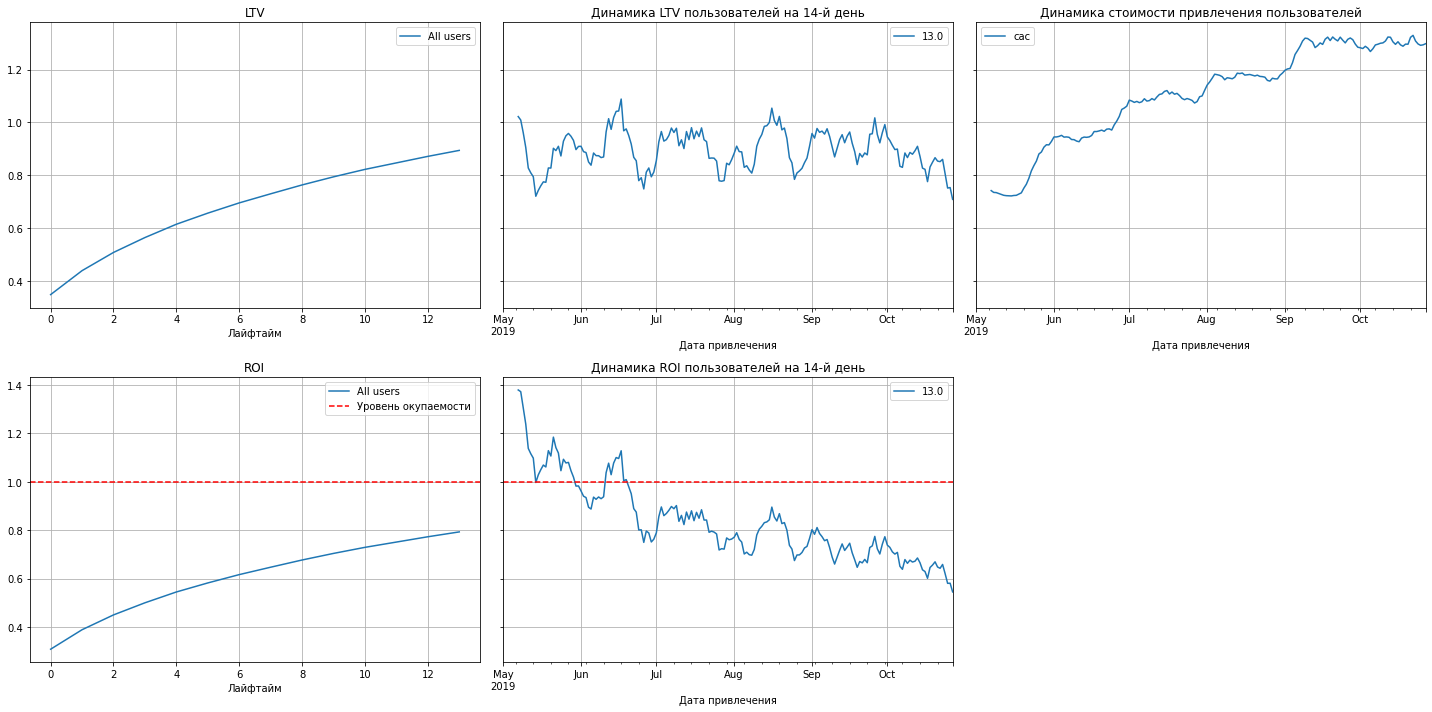

In [35]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    purchased_profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Видим, что стоимость привлечения растёт, реклама не окупается, (по итогу двух недель ROI ниже 80%), LTV стабилен. Значит проблема в расходах, а не в доходах. На всякий случай посмотрем по всем характеристикам, оставив канал привлечения на потом, так как помним, что с TipTop были проблемки.

LTV по странам

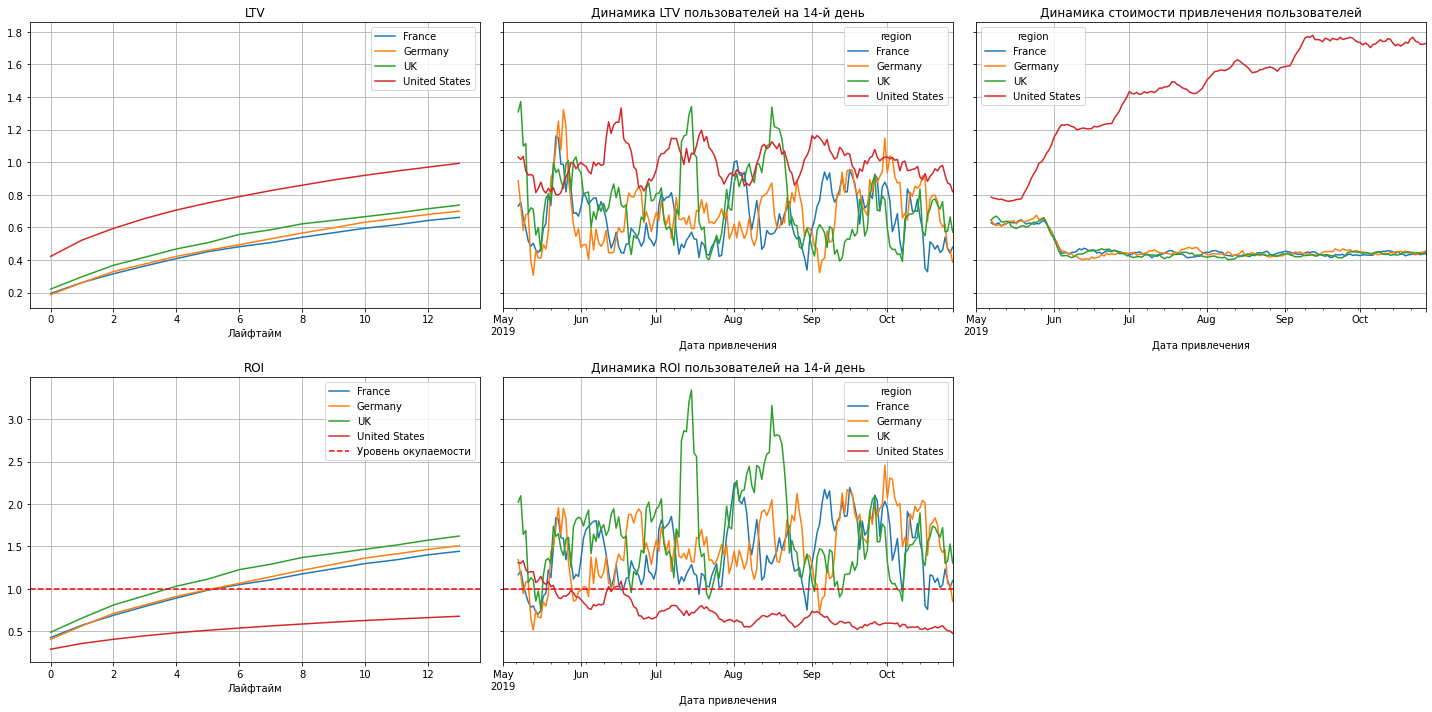

In [36]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    purchased_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Видим, что LTV американцев значительно выше, чем у всех остальных, однако именно америка не окупается. При этом стоимость привлечения пользователей из америки росла в течении 5 месяцев подряд и, в итоге, оказалась в 4.5 раза выше, чем стоимость привлечения пользователей из других стран.

Делаем вывод - что-то не так с пользователями из US: платить они хотят, платить они продолжают, но увелечиние расходов на их привлечение никак не помогает, а только мешает.

LTV по устройствам

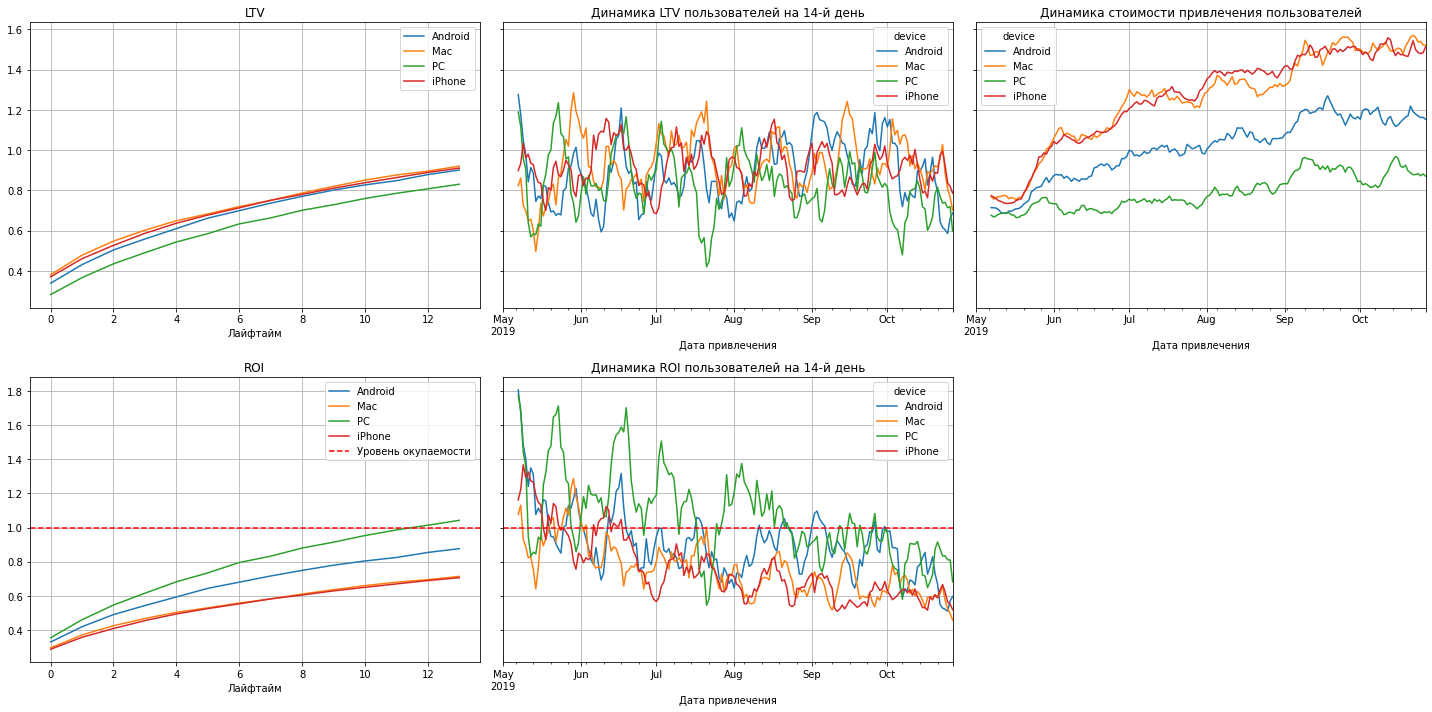

In [37]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    purchased_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Стоимость привлечения растёт для всех платформ, особенно для Mac и iPhone. Исходя из прошлых наблюдений можем предположить, что в США эти платформы любят больше, чем Android и PC. С трудом окупаются только пользователи, использующие PC, но дела плохи у всех.

LTV по каналам привлечения

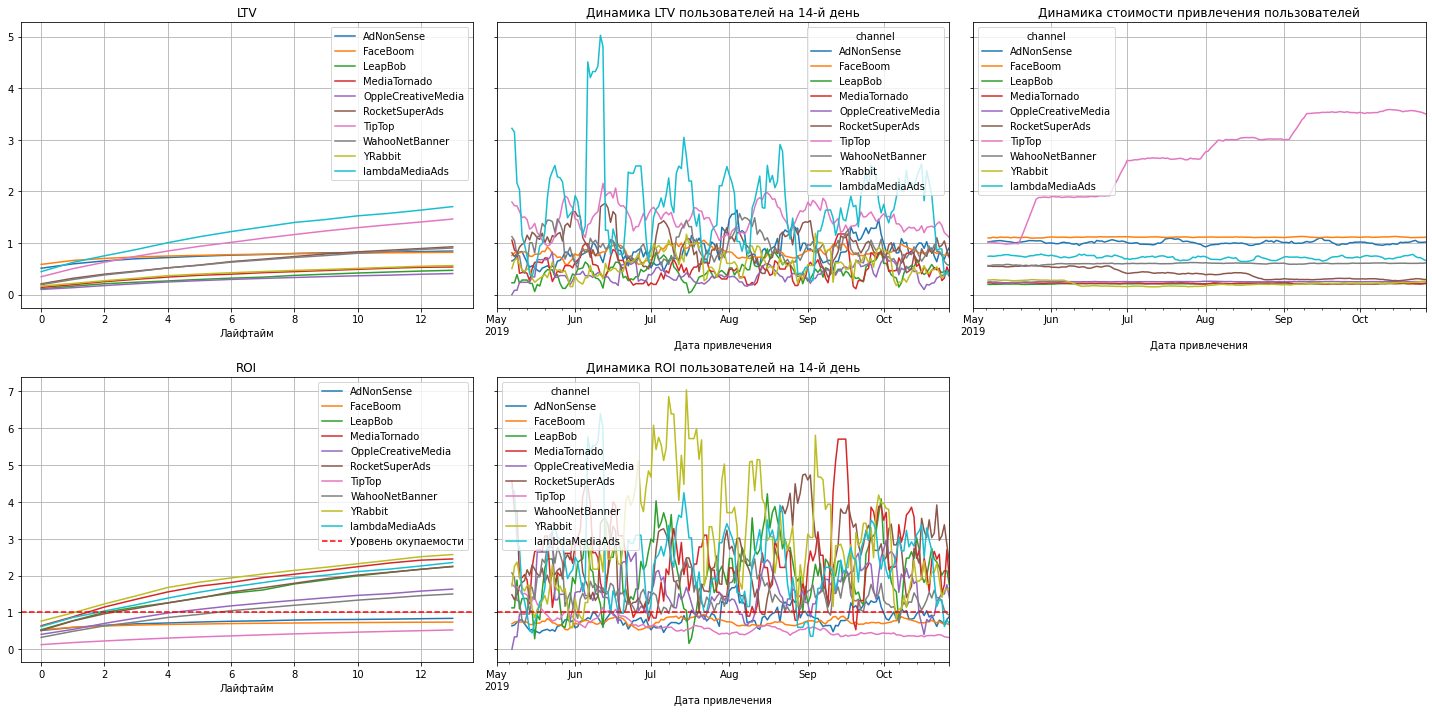

In [38]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    purchased_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Видим, что не окупаются три канала: Faceboom, TipTop и AdNonSense. Ранее мы выясинили, что стоимость привлечения для этих каналов больше 1 (1.1, 2.8 и 1.0008 соответственно). Также видим, что стоимость привлечения TipTop увеличивалась 4 раза.

Предполагаем, что несколько раз проводились рекламные компании в TipTop, который популярен в US, с целью привлечь больше американцев, так как они больше всех платят, однако все эти компании оказались неудачными.

Визуализируем конверсию и удержание

По устройствам

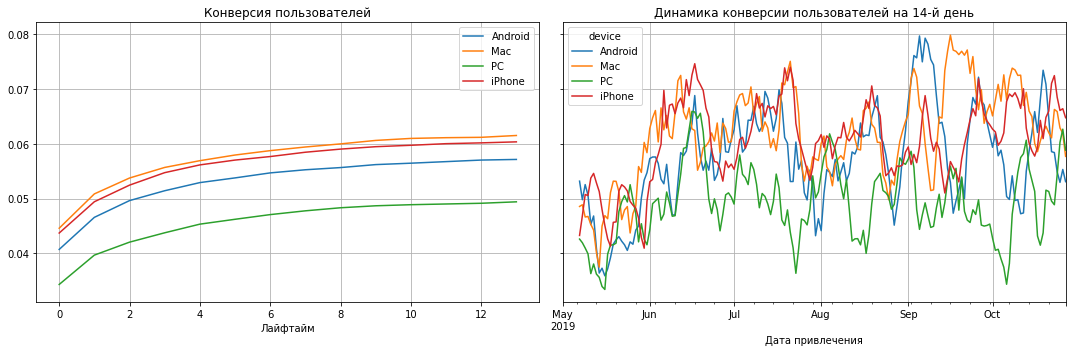

In [39]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

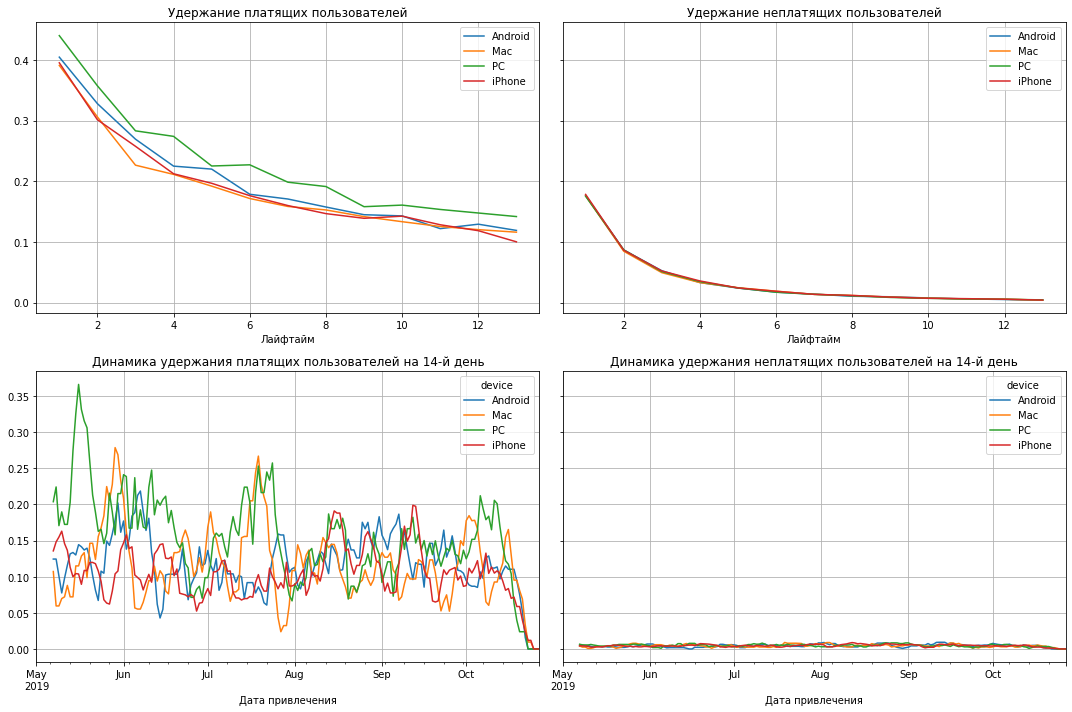

In [40]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

В целом всё нормально. Можно отметить, что пользователи PC хуже конвертируются, однако лучше удерживаются.

По странам

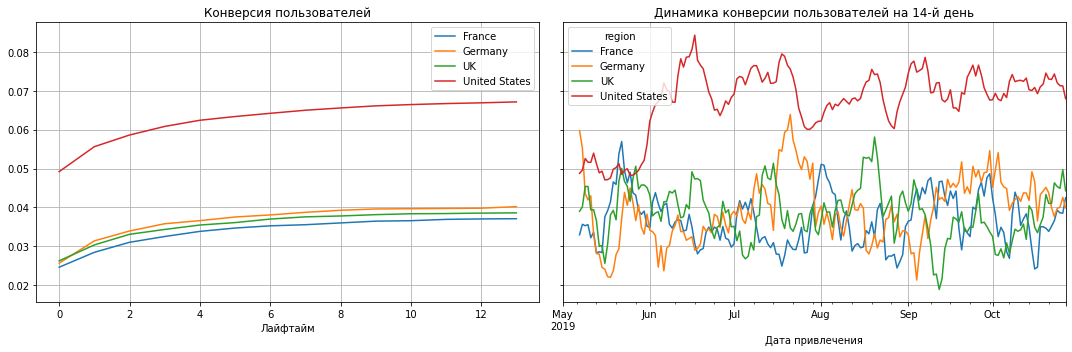

In [41]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

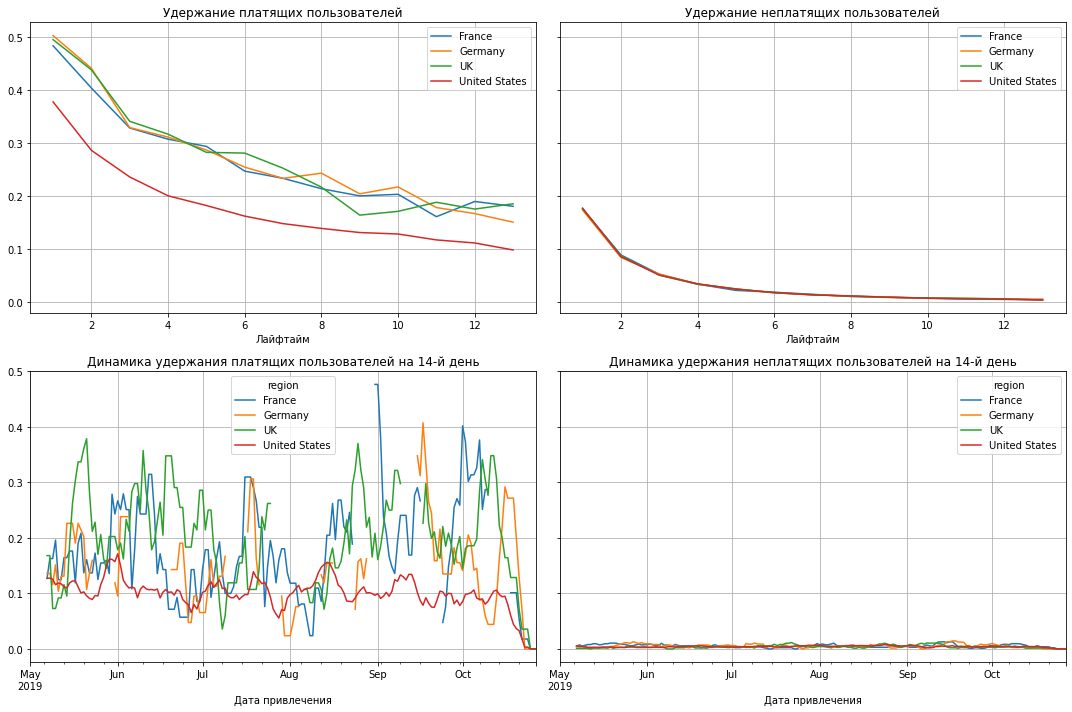

In [42]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Видим, что в момент старта рекламной компании в TipTop в июне, конверсия пользователей из US значительно выросла, однако удержать этих пользователей оказалось сложнее, чем привлечь.

По каналам привлечения

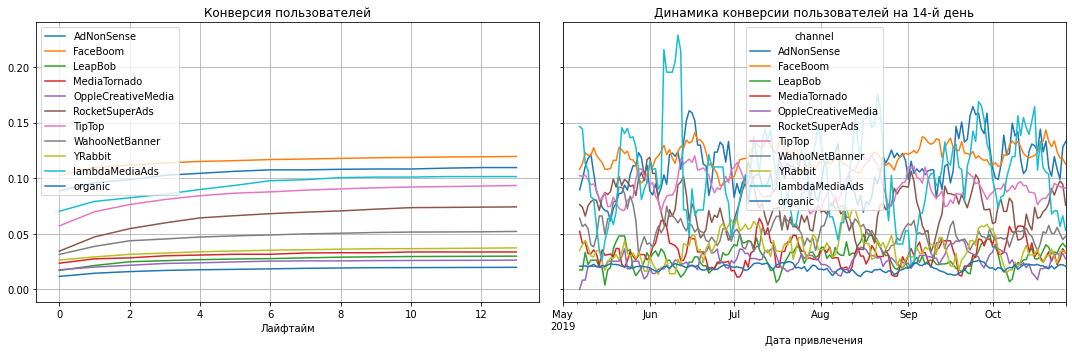

In [43]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

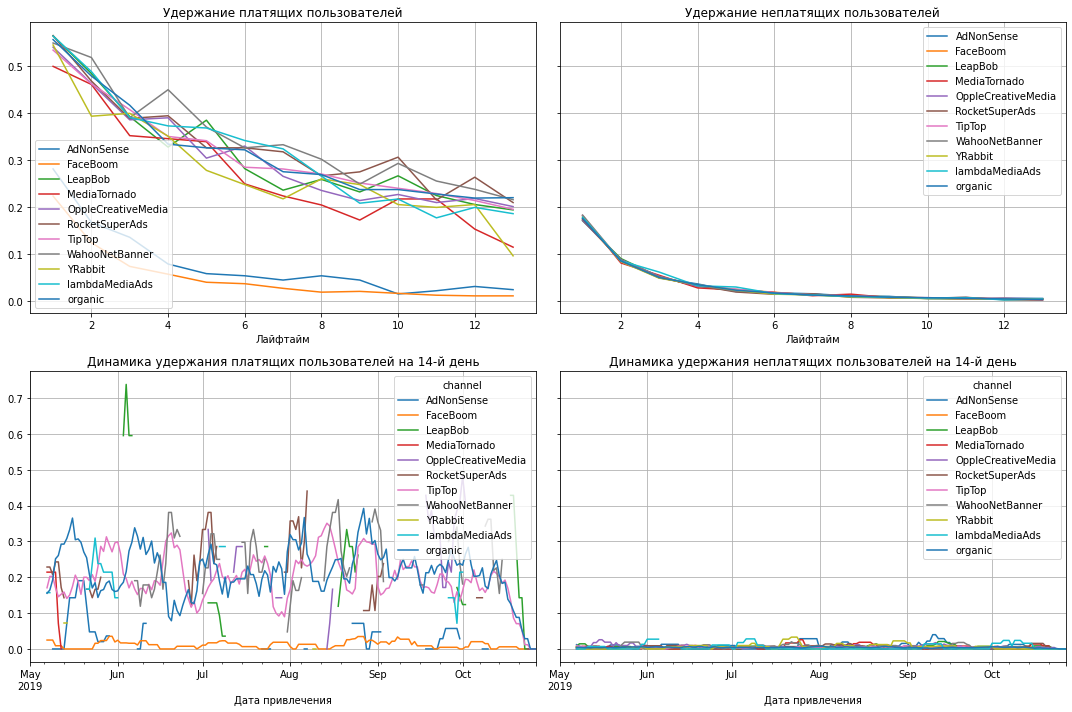

In [44]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Видим, что сравнительно высокая конверсия пользователей, привлечённых через TipTop и FaceBoom разбивается о невозможность удержать этих пользователей.

**Промежуточные выводы 3**

Пользователи из US больше платят и лучше конвертируются, однако хуже удерживаются.
Пользователи, привлечённые в FaceBoom и TipTop плохо удерживаются.
Рекламные компании в FaceBoom и TipTop не окупаются.

## Этап 3. Результаты исследования

#### Выводы

В целом реклама не окупается.

Можем предположить, что из-за сравнительно высокого LTV пользователей из US, было принято решение сосредоточиться на привлечении этих пользователей. Для этого были определены популярные в Соединённых Штатах платформы: FaceBoom и TipTop, и были выделены средства для рекламы в них. При этом для FaceBoom рекламный бюджет не менялся от месяца к месяцу, а для TipTop постоянно увеличивался. Это позволило привлечь больше клиентов и увеличить их конверсию, однако возникли проблемы с удержанием.

Исходя из этого можно сделать вывод, что происходило привлечение неправильной аудитории - привлечённые пользователи быстро теряли интерес к нашему приложению.

#### Рекомендации

Делаем рекомендацию - продолжать привлекать пользователей из US, однако либо как-то менять рекламу, чтобы привлекать более заинтересованных в нашем продукте пользователей, либо работать над удержанием привлекаемых пользователей, либо вснижать САС до 0.7-0.8, так как каналы с таким САС окупаются.